# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Objective of the project is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. Not all users receive the same offer, and that is the challenge to solve with this data set.

Some users might make a purchase through the app without having received an offer or seen an offer. So the approach here is to first find the users who have received an offer and viewed it, and then find users who have completed that offer within the validity period of that offer. This gives the actual dataset of users who have influenced by Starbucks offers and responded to it. We can analyse this data to find out which type of offers can be given to which group of users. Also creates a machine learning model to predict the offer type that can be given to a demographic group.



# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics  import accuracy_score

import warnings
warnings.filterwarnings('ignore', '.*feature names.*')

%matplotlib inline



In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## 1. Exploring Data

In [3]:
def explore_data(df):
    display(df.head())
    print(f"\nShape : {df.shape}")
    print(f"\nDescriptive statistics: \n {df.describe()}")
    print(f"\nNull values: \n{df.isna().sum()}")

In [4]:
explore_data(portfolio)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7



Shape : (10, 6)

Descriptive statistics: 
           reward  difficulty   duration
count  10.000000   10.000000  10.000000
mean    4.200000    7.700000   6.500000
std     3.583915    5.831905   2.321398
min     0.000000    0.000000   3.000000
25%     2.000000    5.000000   5.000000
50%     4.000000    8.500000   7.000000
75%     5.000000   10.000000   7.000000
max    10.000000   20.000000  10.000000

Null values: 
reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64


In [5]:
explore_data(profile)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN



Shape : (17000, 5)

Descriptive statistics: 
                 age  became_member_on         income
count  17000.000000      1.700000e+04   14825.000000
mean      62.531412      2.016703e+07   65404.991568
std       26.738580      1.167750e+04   21598.299410
min       18.000000      2.013073e+07   30000.000000
25%       45.000000      2.016053e+07   49000.000000
50%       58.000000      2.017080e+07   64000.000000
75%       73.000000      2.017123e+07   80000.000000
max      118.000000      2.018073e+07  120000.000000

Null values: 
gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64


In [6]:
explore_data(transcript)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0



Shape : (306534, 4)

Descriptive statistics: 
                 time
count  306534.000000
mean      366.382940
std       200.326314
min         0.000000
25%       186.000000
50%       408.000000
75%       528.000000
max       714.000000

Null values: 
person    0
event     0
value     0
time      0
dtype: int64


## 2. Exploratory Data Analysis

### 2.1. Data Cleaning

#### portfolio

In [7]:
# Rename column 'id' to 'offer_id'
portfolio.rename(columns={'id':'offer_id'}, inplace=True)

In [8]:
# Conver channels into different columns
channels = set(sum(portfolio['channels'], []))
for ch in channels:
    portfolio[ch] = portfolio['channels'].apply(lambda x:1 if ch in x else 0)
portfolio.drop(columns='channels', inplace=True)

In [9]:
portfolio

,reward,difficulty,duration,offer_type,offer_id,web,email,mobile,social
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,1,0


#### profile

##### Eliminate invalid profiles

In [10]:
profile[profile['gender'].isnull()].head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN


In [11]:
print(profile[profile['gender'].isnull()]['age'].value_counts())
print(profile[profile['income'].isnull()]['age'].value_counts())

118    2175
Name: age, dtype: int64
118    2175
Name: age, dtype: int64


For users with age=118 does not have any information about gender and income. So those records can be removed.

In [12]:
# Drop nan values
profile.dropna(inplace=True)
profile.reset_index(inplace=True, drop=True)
print(profile.count())

gender              14825
age                 14825
id                  14825
became_member_on    14825
income              14825
dtype: int64


In [13]:
# Rename column 'id' to 'customer_id'
profile.rename(columns={'id':'customer_id'}, inplace=True)

In [14]:
# convert 'became_member_on' to 'year_of_joining'
profile['year_of_joining'] = profile['became_member_on'] \
                             .apply(lambda x:datetime.strptime(str(x), '%Y%m%d').year)
profile.drop('became_member_on', axis=1, inplace=True)

In [15]:
profile.head()

,gender,age,customer_id,income,year_of_joining
0,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,2017
1,F,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017
2,M,68,e2127556f4f64592b11af22de27a7932,70000.0,2018
3,M,65,389bc3fa690240e798340f5a15918d5c,53000.0,2018
4,M,58,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017


##### Convert age to categorical data 

/home/girishkumarpr/anaconda3/envs/DS/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Age Boxplot')

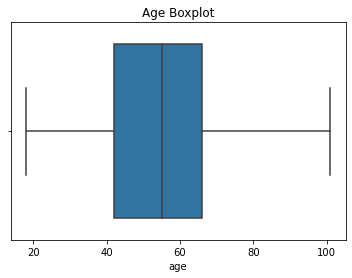

In [16]:
sns.boxplot(profile['age'])
plt.title('Age Boxplot')

In [17]:
labels = ['below 20', '20s', '30s', '40s', '50s', '60s', '70s', '80+']
bins=[1, 19, 29, 39, 49, 59, 69, 79, 110]
profile['age'] = pd.cut(profile['age'], bins=bins, labels=labels)
profile.head()

,gender,age,customer_id,income,year_of_joining
0,F,50s,0610b486422d4921ae7d2bf64640c50b,112000.0,2017
1,F,70s,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017
2,M,60s,e2127556f4f64592b11af22de27a7932,70000.0,2018
3,M,60s,389bc3fa690240e798340f5a15918d5c,53000.0,2018
4,M,50s,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017


##### Convert income to categorical data 

/home/girishkumarpr/anaconda3/envs/DS/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Income Boxplot')

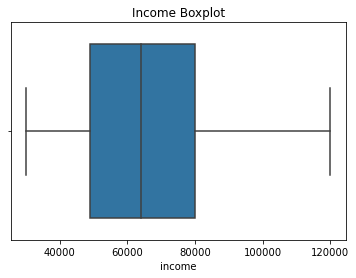

In [18]:
sns.boxplot(profile['income'])
plt.title('Income Boxplot')

In [19]:
labels = ['below 40k', '40k-50k', '50k-60k', '60k-70k', '70k-80k', 'above 80k']
bins=[1, 39999, 49999, 59999, 69999, 79999, 120000]
profile['income'] = pd.cut(profile['income'], bins=bins, labels=labels)
profile.head()

,gender,age,customer_id,income,year_of_joining
0,F,50s,0610b486422d4921ae7d2bf64640c50b,above 80k,2017
1,F,70s,78afa995795e4d85b5d9ceeca43f5fef,above 80k,2017
2,M,60s,e2127556f4f64592b11af22de27a7932,70k-80k,2018
3,M,60s,389bc3fa690240e798340f5a15918d5c,50k-60k,2018
4,M,50s,2eeac8d8feae4a8cad5a6af0499a211d,50k-60k,2017


#### transcript

In [20]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [21]:
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

##### Split value into different columns

In [22]:
value_df = pd.io.json.json_normalize(transcript['value'])
value_df['offer_id'] = np.where(value_df['offer_id'].isnull(), value_df['offer id'], value_df['offer_id'])
value_df.head()

/tmp/ipykernel_39859/1311162170.py:1: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  value_df = pd.io.json.json_normalize(transcript['value'])


,offer id,amount,offer_id,reward
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,2906b810c7d4411798c6938adc9daaa5,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
3,fafdcd668e3743c1bb461111dcafc2a4,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [23]:
transcript = transcript.join(value_df.drop('offer id', axis=1)).drop(['value'], axis=1)
transcript.rename(columns={'person':'customer_id', 'reward':'reward_received'}, inplace=True)
transcript.head()

,customer_id,event,time,amount,offer_id,reward_received
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [24]:
transcript.shape

(306534, 6)

In [25]:
transcript['customer_id'].nunique(), profile['customer_id'].nunique()

(17000, 14825)

In [26]:
# Drop records with customer_id not in profile data
transcript= transcript[transcript['customer_id'].isin(profile['customer_id'])]

In [27]:
transcript.shape, transcript['customer_id'].nunique()

((272762, 6), 14825)

In [28]:
transcript.head()

,customer_id,event,time,amount,offer_id,reward_received
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
5,389bc3fa690240e798340f5a15918d5c,offer received,0,NaN,f19421c1d4aa40978ebb69ca19b0e20d,NaN
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,0,NaN,3f207df678b143eea3cee63160fa8bed,NaN
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN


### 2.2. Pre-processing


##### Merge transcript and portfolio tables

In [29]:
df_agg = pd.merge(transcript, portfolio, on=['offer_id'], how='left')
print(df_agg.shape)
df_agg.head(2)

(272762, 14)


,customer_id,event,time,amount,offer_id,reward_received,reward,difficulty,duration,offer_type,web,email,mobile,social
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5.0,5.0,7.0,bogo,1.0,1.0,1.0,0.0
1,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,2.0,10.0,7.0,discount,1.0,1.0,1.0,0.0


##### Rename offer ids to more readable form

In [30]:
offerid_mapper = {'ae264e3637204a6fb9bb56bc8210ddfd': 'bogo_1',
                  '4d5c57ea9a6940dd891ad53e9dbe8da0': 'bogo_2',
                  '3f207df678b143eea3cee63160fa8bed': 'informational_1',
                  '9b98b8c7a33c4b65b9aebfe6a799e6d9': 'bogo_3',
                  '0b1e1539f2cc45b7b9fa7c272da2e1d7': 'discount_1',
                  '2298d6c36e964ae4a3e7e9706d1fb8c2': 'discount_2',
                  'fafdcd668e3743c1bb461111dcafc2a4': 'discount_3',
                  '5a8bc65990b245e5a138643cd4eb9837': 'informational_2',
                  'f19421c1d4aa40978ebb69ca19b0e20d': 'bogo_4',
                  '2906b810c7d4411798c6938adc9daaa5': 'discount_4'
                 }


conditions  = [df_agg['offer_id']== i for i in offerid_mapper.keys()]
choices     = [ offerid_mapper[i] for i in offerid_mapper.keys()]

df_agg['offer_id'] = np.select(conditions, choices, default=df_agg['offer_id'])

df_agg.head()

,customer_id,event,time,amount,offer_id,reward_received,reward,difficulty,duration,offer_type,web,email,mobile,social
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,bogo_3,NaN,5.0,5.0,7.0,bogo,1.0,1.0,1.0,0.0
1,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,discount_4,NaN,2.0,10.0,7.0,discount,1.0,1.0,1.0,0.0
2,389bc3fa690240e798340f5a15918d5c,offer received,0,NaN,bogo_4,NaN,5.0,5.0,5.0,bogo,1.0,1.0,1.0,1.0
3,2eeac8d8feae4a8cad5a6af0499a211d,offer received,0,NaN,informational_1,NaN,0.0,0.0,4.0,informational,1.0,1.0,1.0,0.0
4,aa4862eba776480b8bb9c68455b8c2e1,offer received,0,NaN,discount_1,NaN,5.0,20.0,10.0,discount,1.0,1.0,0.0,0.0


In [31]:
df_agg['event'].value_counts()

transaction        123957
offer received      66501
offer viewed        49860
offer completed     32444
Name: event, dtype: int64

,offer_type,received,viewed,completed
0,discount,26664,18461,17186.0
1,bogo,26537,22039,15258.0
2,informational,13300,9360,NaN


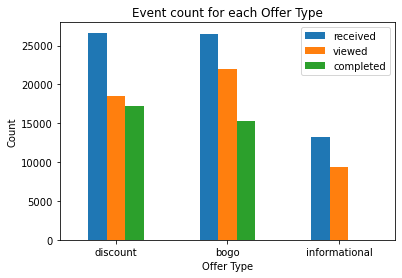

In [32]:
received_df = df_agg[df_agg['event']=='offer received']
type_df = pd.DataFrame()
type_df['received'] = received_df['offer_type'].value_counts()
type_df['viewed'] = df_agg[df_agg['event']=='offer viewed']['offer_type'].value_counts()
type_df['completed'] = df_agg[df_agg['event']=='offer completed']['offer_type'].value_counts()
type_df.reset_index(inplace=True)
type_df.rename(columns={'index':'offer_type'}, inplace=True)

ax = type_df.plot(x='offer_type', y=['received', 'viewed', 'completed'], kind='bar',
                 title='Event count for each Offer Type', rot=0)
ax.set_xlabel('Offer Type')
ax.set_ylabel('Count')

type_df

,offer_id,received,viewed,completed
0,discount_1,6726,2215,3386.0
1,bogo_3,6685,3499,4188.0
2,bogo_1,6683,5901,3657.0
3,informational_1,6657,3487,NaN
4,discount_2,6655,6379,4886.0
5,discount_3,6652,6407,5003.0
6,informational_2,6643,5873,NaN
7,discount_4,6631,3460,3911.0
8,bogo_2,6593,6329,3310.0
9,bogo_4,6576,6310,4103.0


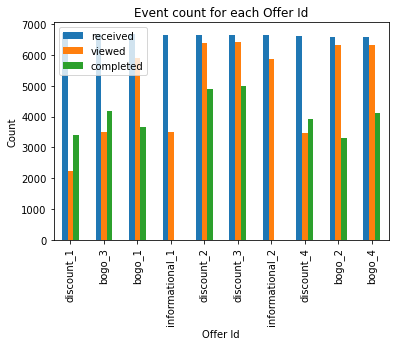

In [33]:
id_df = pd.DataFrame()
id_df['received'] = received_df['offer_id'].value_counts()
id_df['viewed'] = df_agg[df_agg['event']=='offer viewed']['offer_id'].value_counts()
id_df['completed'] = df_agg[df_agg['event']=='offer completed']['offer_id'].value_counts()
id_df.reset_index(inplace=True)
id_df.rename(columns={'index':'offer_id'}, inplace=True)

ax = id_df.plot(x='offer_id', y=['received', 'viewed', 'completed'], kind='bar',
                 title='Event count for each Offer Id')
ax.set_xlabel('Offer Id')
ax.set_ylabel('Count')

id_df

From above, it is clear that many offers like bogo_3, discount_1, discount_4 are completed by customers without viewing the offer. So, we need to find customers who actually have seen the offer and then completed it.

### 3.1. Customers who have responded to the offers

A customer is said to be influenced by an offer only if he/she has viewd the offer recieved. A customer recived an offer, never viewed it but completed the offer, is not influenced by the offer.


In [34]:
def influenced_by_offer():
    '''
    Finds the customers responded to an offer.
    Returns a list of (customer_id, offer_id) pair that is 
    influenced by the offer.    
    '''
    group_cols = ['customer_id', 'offer_id']
    group_obj = df_agg[~df_agg['offer_id'].isnull()].groupby(group_cols)['event', 'time', 'duration']
    customer_offer = []

    for grp in group_obj.groups:
        row = group_obj.get_group(grp)
        row.reset_index(drop=True, inplace=True)

        if ('offer viewed' not in (list(row['event']))):
            continue

        validity = 0
        view_status = False
        for i in row.index.values:
            if row['event'][i]=='offer received':
                validity = row['time'][i] + 24 * row['duration'][i]
                view_status = False
                continue
            if ((row['event'][i]=='offer viewed') & (row['time'][i] < validity)):
                view_status = True
            if row['event'][i]=='offer completed':
                validity = 0
                if view_status:
                    offer_type = grp[1].split('_')[0]
                    customer_offer.append([grp[0], grp[1], offer_type])
                    
                    view_status = False
                    break
    return customer_offer
        
        
customer_offer = influenced_by_offer()


/tmp/ipykernel_39859/776032149.py:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  group_obj = df_agg[~df_agg['offer_id'].isnull()].groupby(group_cols)['event', 'time', 'duration']


In [35]:
customer_offer_df = pd.DataFrame(customer_offer, columns=['customer_id', 'offer_id', 'offer_type'])
customer_offer_df.shape, customer_offer_df['customer_id'].nunique(), customer_offer_df['offer_id'].value_counts()

((20027, 3),
 10860,
 discount_3    3784
 discount_2    3618
 bogo_4        2993
 bogo_2        2422
 bogo_1        2300
 bogo_3        1861
 discount_4    1848
 discount_1    1201
 Name: offer_id, dtype: int64)

For informational offers, there is no offer completed event. So it is assumed that if a customer is influenced by an informational offer, if he/she viewed the offer and made a transaction (with amount greater than difficulty level) within the validity period of that offer.

In [36]:
info_df = df_agg[~df_agg['offer_type'].isin(['bogo','discount'])]

def influenced_by_information():
    '''
    Finds the customers responded to an informational offer.
    Returns a list of (customer_id, offer_id) pair that is 
    influenced by the offer.    
    '''
    group_obj = df_agg[~df_agg['offer_type'].isin(['bogo','discount'])] \
                     .groupby('customer_id')['event', 'offer_id', 'time', 'duration', 'amount']
    
    customer_offer = []

    for grp in group_obj.groups:
        row = group_obj.get_group(grp)
        row.reset_index(drop=True, inplace=True)

        if ('offer viewed' not in (list(row['event']))):
            continue

        validity = 0
        view_status = False
        for i in row.index.values:
            if row['event'][i]=='offer received':
                validity = row['time'][i] + 24 * row['duration'][i]
                view_status = False
                continue
            if ((row['event'][i]=='offer viewed') & (row['time'][i] < validity)):
                view_status = True
                offer_id = row['offer_id'][i]
                offer_type = row['offer_id'][i].split('_')[0]
            if ((row['event'][i]=='transaction')  & (row['time'][i] < validity)):
                if ((view_status) & (row['amount'][i]>0)):
                    customer_offer.append((grp, offer_id, offer_type))
                    view_status = False

    return list(set(customer_offer))


customer_informational = influenced_by_information()

/tmp/ipykernel_39859/3801767449.py:9: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  group_obj = df_agg[~df_agg['offer_type'].isin(['bogo','discount'])] \


In [37]:
customer_informational_df = pd.DataFrame(customer_informational, columns=['customer_id', 'offer_id', 'offer_type'])
print(customer_informational_df['offer_id'].value_counts())
customer_informational_df.head()

informational_2    2798
informational_1    1708
Name: offer_id, dtype: int64


,customer_id,offer_id,offer_type
0,4bcd890290d446239306584a3eb0d3fb,informational_1,informational
1,b62baaff868b45768e674828aef381b4,informational_2,informational
2,7eb248dd7ac546a4931a3e0ad67d0286,informational_1,informational
3,37ce8e0c55ea4cf4a7b09f3a71550a40,informational_2,informational
4,13fec8f3cfae4ca186eab06b75cb3cec,informational_2,informational


          offer_id  received  responded  response_rate
0       discount_1      6726       1201      17.856081
1           bogo_3      6685       1861      27.838444
2           bogo_1      6683       2300      34.415682
3  informational_1      6657       1708      25.657203
4       discount_2      6655       3618      54.365139
5       discount_3      6652       3784      56.885147
6  informational_2      6643       2798      42.119524
7       discount_4      6631       1848      27.869100
8           bogo_2      6593       2422      36.735932
9           bogo_4      6576       2993      45.513990


Text(0, 0.5, 'Percent')

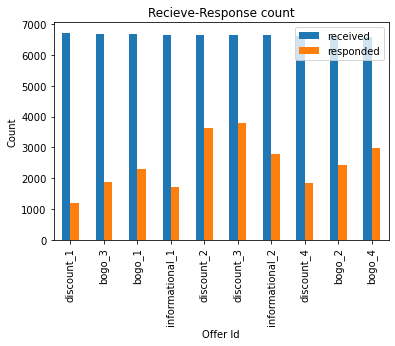

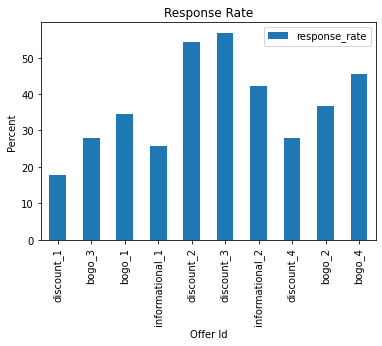

In [38]:
response_df = pd.concat([customer_offer_df, customer_informational_df])

# print(response_df['offer_id'].value_counts())
# print(received_offers['offer_id'].value_counts())

comp_df = pd.DataFrame()
comp_df['received'] = received_df['offer_id'].value_counts()
comp_df['responded'] = response_df['offer_id'].value_counts()
comp_df['response_rate'] = comp_df['responded']/comp_df['received'] * 100
comp_df.reset_index(inplace=True)
comp_df.rename(columns={'index':'offer_id'}, inplace=True)
print(comp_df)

count_plot = comp_df.plot(x='offer_id', y=['received', 'responded'], kind='bar', title='Recieve-Response count')
count_plot.set_xlabel('Offer Id')
count_plot.set_ylabel('Count')

rate_plot = comp_df.plot(x='offer_id', y=['response_rate'], kind='bar', title='Response Rate') 
rate_plot.set_xlabel('Offer Id')
rate_plot.set_ylabel('Percent')
# response_df.head()

      offer_type  received  responded  response_rate
0       discount     26664      10451      39.195170
1           bogo     26537       9576      36.085466
2  informational     13300       4506      33.879699


Text(0, 0.5, 'Percent')

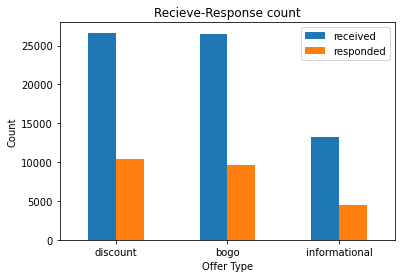

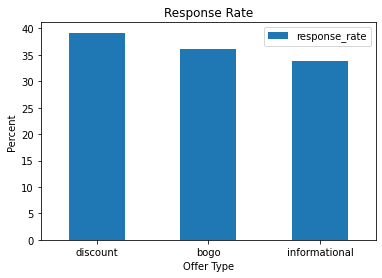

In [39]:
response_df.head() 
comp_df = pd.DataFrame()
comp_df['received'] = received_df['offer_type'].value_counts()
comp_df['responded'] = response_df['offer_type'].value_counts()
comp_df['response_rate'] = comp_df['responded']/comp_df['received'] * 100
comp_df.reset_index(inplace=True)
comp_df.rename(columns={'index':'offer_type'}, inplace=True)
print(comp_df)
count_plot = comp_df.plot(x='offer_type', y=['received', 'responded'], kind='bar', title='Recieve-Response count', rot=0) 
count_plot.set_xlabel('Offer Type')
count_plot.set_ylabel('Count')

rate_plot = comp_df.plot(x='offer_type', y=['response_rate'], kind='bar', title='Response Rate', rot=0) 
rate_plot.set_xlabel('Offer Type')
rate_plot.set_ylabel('Percent')

Here we can see that all types of offers have response rate of above 33%, and discount rate tops the list.

##### Merge response and profile tables

In [40]:
response_demo_df = pd.merge(response_df, profile, on=['customer_id'], how='left')
print(response_demo_df.shape)
response_demo_df.head()

(24533, 7)


,customer_id,offer_id,offer_type,gender,age,income,year_of_joining
0,0011e0d4e6b944f998e987f904e8c1e5,bogo_3,bogo,O,40s,50k-60k,2018
1,0011e0d4e6b944f998e987f904e8c1e5,discount_1,discount,O,40s,50k-60k,2018
2,0011e0d4e6b944f998e987f904e8c1e5,discount_2,discount,O,40s,50k-60k,2018
3,0020c2b971eb4e9188eac86d93036a77,bogo_2,bogo,F,50s,above 80k,2016
4,0020c2b971eb4e9188eac86d93036a77,discount_3,discount,F,50s,above 80k,2016


### 3.2. Popular offers

Text(0.5, 0, 'Age Group')

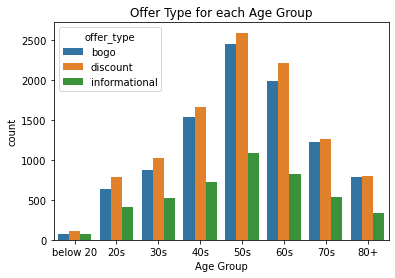

In [41]:
sns.countplot(x="age", hue="offer_type", data=response_demo_df)
plt.title('Offer Type for each Age Group')
plt.xlabel('Age Group')

**Customers in the age group 50s and 60s are more responsive to offers.**

In [42]:
received_demo_df = pd.merge(received_df, profile, on=['customer_id'], how='left')
print(received_demo_df.shape)
# print(response_demo_df['gender'].value_counts())
# print(received_demo_df['gender'].value_counts())


(66501, 18)


Response rate: 
 M    0.339820
F    0.406432
O    0.455240
Name: gender, dtype: float64


Text(0.5, 1.0, 'Received')

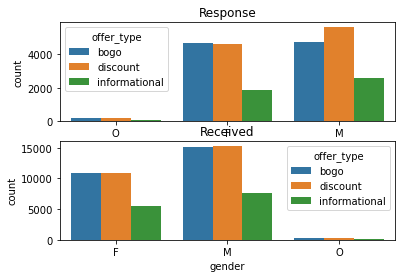

In [43]:
print("Response rate: \n", response_demo_df['gender'].value_counts()/received_demo_df['gender'].value_counts())
plt.subplot(2,1,1)
sns.countplot(x="gender", hue="offer_type", data=response_demo_df)
plt.title('Response')
plt.xlabel('Gender')

plt.subplot(2,1,2)
sns.countplot(x="gender", hue="offer_type", data=received_demo_df)
plt.title('Received')
# plt.xlabel('Gender')

**Male users respond to more 'discount' and 'informational' offers compared to female users, but the response rate is more for females.**

Text(0.5, 0, 'Offer Id')

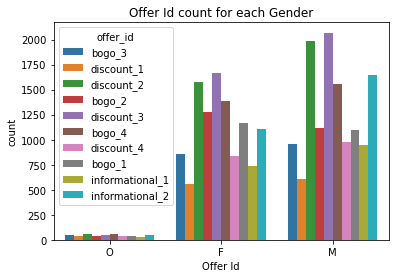

In [44]:
sns.countplot(x="gender", hue="offer_id", data=response_demo_df)
plt.title('Offer Id count for each Gender')
plt.xlabel('Offer Id')

**Males respond more to discount_3, discount_2 and informational_2 offers compared to other offers.**

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'below 40k'),
  Text(1, 0, '40k-50k'),
  Text(2, 0, '50k-60k'),
  Text(3, 0, '60k-70k'),
  Text(4, 0, '70k-80k'),
  Text(5, 0, 'above 80k')])

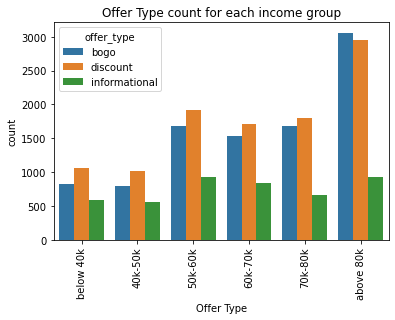

In [45]:
sns.countplot(x="income", hue="offer_type", data=response_demo_df)
plt.title('Offer Type count for each income group')
plt.xlabel('Offer Type')
plt.xticks(rotation = 90)

Here we can see that **customers with income above 80k respond more to all types of offer.**

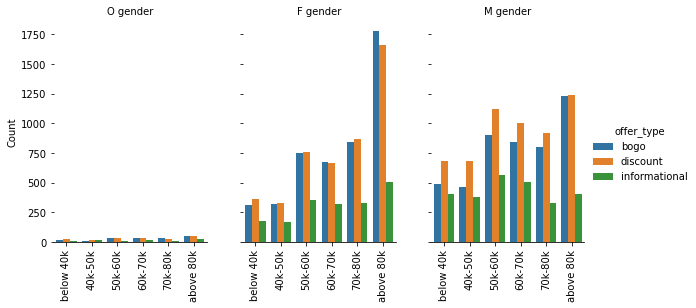

In [46]:
g = sns.catplot(x="income", hue="offer_type", col="gender",
                data=response_demo_df, kind="count",
                height=4, aspect=.7)
g.set_axis_labels("", "Count") \
  .set_xticklabels(response_demo_df['income'].astype('category').cat.categories.tolist()) \
  .set_titles("{col_name} {col_var}") \
  .set_xticklabels(rotation=90) \
  .despine(left=True)


Above plot shows that **users with income greater than 80k are more responsive to offers, irrespective of their gender.** 
Female users with income greater than 80k respond more to all three types of offers.
For 'bogo' and 'discount' offers, male users with income greater than 80k respond more, whereas for informational offers, male users in the income category 50k-60k respond more. 

Now let us check the age and income wise distribution of offers for each gender.

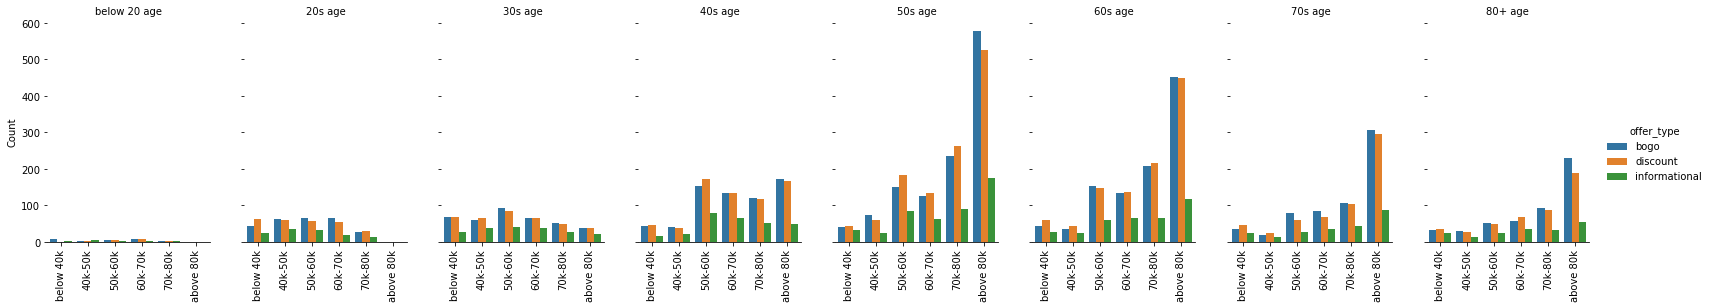

In [47]:
income_list = response_demo_df['income'].astype('category').cat.categories.tolist()

# Age and income wise distribution for Female users"
female_df = response_demo_df[response_demo_df['gender']=='F']
g = sns.catplot(x="income", hue="offer_type", col="age",
                data=female_df, kind="count",
                height=4, aspect=.7)
g.set_axis_labels("", "Count") \
  .set_xticklabels(income_list) \
  .set_titles("{col_name} {col_var}") \
  .set_xticklabels(rotation=90) \
  .despine(left=True)


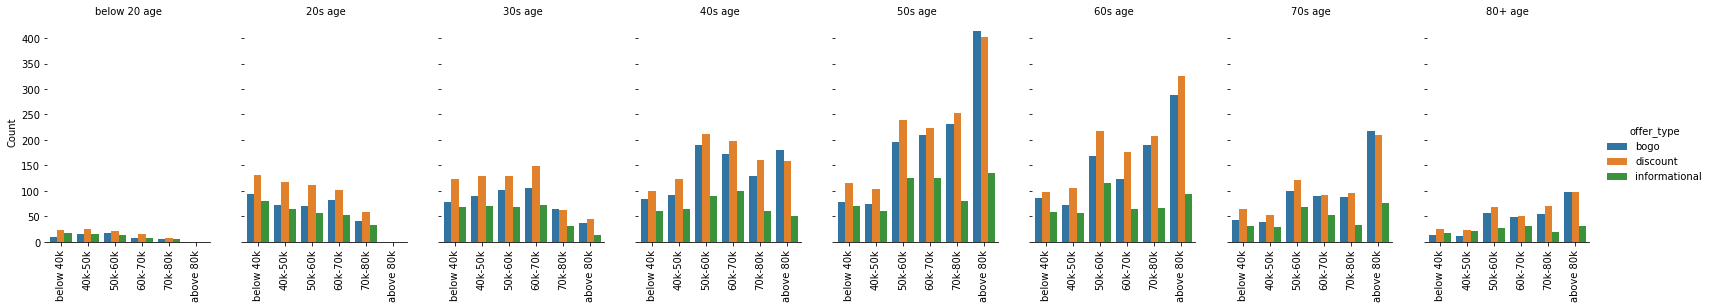

In [48]:
# Age and income wise distribution for Male users"
male_df = response_demo_df[response_demo_df['gender']=='M']
g = sns.catplot(x="income", hue="offer_type", col="age",
                data=male_df, kind="count",
                height=4, aspect=.7)
g.set_axis_labels("", "Count") \
  .set_xticklabels(income_list) \
  .set_titles("{col_name} {col_var}") \
  .set_xticklabels(rotation=90) \
  .despine(left=True)


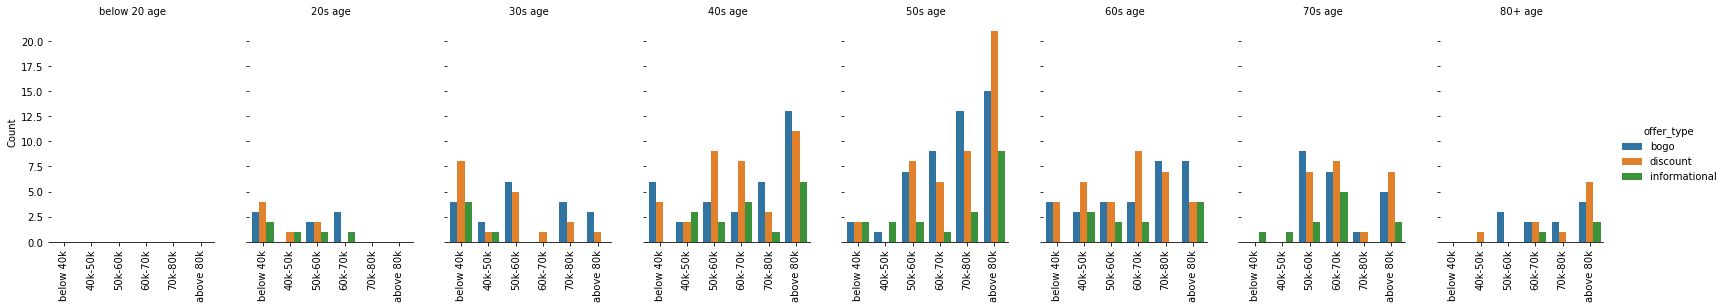

In [49]:
# Age and income wise distribution for Other users"
other_df = response_demo_df[response_demo_df['gender']=='O']
g = sns.catplot(x="income", hue="offer_type", col="age",
                data=other_df, kind="count",
                height=4, aspect=.7)
g.set_axis_labels("", "Count") \
  .set_xticklabels(income_list) \
  .set_titles("{col_name} {col_var}") \
  .set_xticklabels(rotation=90) \
  .despine(left=True)


From above visualisation, we can clearly say which offer type should be given to each of the demographic groups.

## 4. Data Modelling

#### Build a model to predict which type of offers should be given to a customer

### 4.1. Data Preparation

##### Convert Categorical columns to numerical columns:

In [50]:
ot = response_demo_df['offer_type'].astype('category').cat.categories.tolist()
offer_type_map = { v:i for i, v in enumerate(ot)}
oi = response_demo_df['offer_id'].astype('category').cat.categories.tolist()
offer_id_map = { v:i for i, v in enumerate(oi)}
ag = response_demo_df['age'].astype('category').cat.categories.tolist()
age_map = { v:i for i, v in enumerate(ag)}
gm = response_demo_df['gender'].astype('category').cat.categories.tolist()
gender_map = { v:i for i, v in enumerate(gm)}
ig = response_demo_df['income'].astype('category').cat.categories.tolist()
income_map = { v:i for i, v in enumerate(ig)}

df_final = response_demo_df.copy()
df_final.replace(offer_type_map, inplace=True)
df_final.replace(offer_id_map, inplace=True)
df_final.replace(age_map, inplace=True)
df_final.replace(gender_map, inplace=True)
df_final.replace(income_map, inplace=True)
df_final.head()

,customer_id,offer_id,offer_type,gender,age,income,year_of_joining
0,0011e0d4e6b944f998e987f904e8c1e5,2,0,2,3,2,2018
1,0011e0d4e6b944f998e987f904e8c1e5,4,1,2,3,2,2018
2,0011e0d4e6b944f998e987f904e8c1e5,5,1,2,3,2,2018
3,0020c2b971eb4e9188eac86d93036a77,1,0,0,4,5,2016
4,0020c2b971eb4e9188eac86d93036a77,6,1,0,4,5,2016


In [51]:
df_final.shape, df_final.columns

((24533, 7),
 Index(['customer_id', 'offer_id', 'offer_type', 'gender', 'age', 'income',
        'year_of_joining'],
       dtype='object'))

In [52]:
df_final['offer_type'].value_counts()

1    10451
0     9576
2     4506
Name: offer_type, dtype: int64

### 4.2. Build model

##### Splitting data into train and test sets

In [53]:
X = df_final[['age', 'year_of_joining', 'gender', 'income']]
print(X.columns)

y = df_final['offer_type'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

Index(['age', 'year_of_joining', 'gender', 'income'], dtype='object')


((18399, 4), (6134, 4), (18399,), (6134,))

##### Build model

In [54]:
def build_model(classifier):
    
    # print("Classifier: ", str(classifier).split('(')[0])

    # train classifier
    clf = classifier.fit(np.array(X_train), np.array(y_train))
    
    # predict on train and test data
    pred_train = clf.predict(X_train)
    pred_test = clf.predict(X_test)
    
    train_acc = accuracy_score( y_train , pred_train )
    test_acc= accuracy_score( y_test , pred_test )
    # print("Training acc: ", train_acc, "' Test acc: ", test_acc)

    return train_acc, test_acc


In [55]:
names = [
    'Logistic Regression',
    'Decision Tree',
    'Random Forest',
    'Neural Net',
    'AdaBoost',
]

classifiers = [
    LogisticRegression(random_state=40),
    DecisionTreeClassifier(random_state=40),
    RandomForestClassifier(random_state=40),
    MLPClassifier(random_state=40),
    AdaBoostClassifier(random_state=40)
]
result = []
for name, clf in zip(names, classifiers):
    train_acc, test_acc = build_model(clf)
    result.append([name, train_acc, test_acc])

# print(result)
result_df = pd.DataFrame(result, columns=['classifier', 'train_acc', 'test_acc'])
result_df

,classifier,train_acc,test_acc
0,Logistic Regression,0.428610,0.433975
1,Decision Tree,0.466112,0.409358
2,Random Forest,0.466058,0.410988
3,Neural Net,0.392576,0.386534
4,AdaBoost,0.434589,0.430714


#### Find best parameters

In [57]:
from sklearn.model_selection import GridSearchCV

params = {
    'algorithm': ['SAMME', 'SAMME.R'],
    'n_estimators': [40, 45, 50, 55],
    'learning_rate': np.linspace(0.5, 1.2, 8),
    'random_state': [40]
}
cv = GridSearchCV(AdaBoostClassifier(), param_grid=params, n_jobs = -1, scoring='accuracy')

cv.fit(X_train,y_train)
cv.best_params_ 

{'algorithm': 'SAMME.R',
 'learning_rate': 0.8,
 'n_estimators': 40,
 'random_state': 40}

In [58]:
clf = AdaBoostClassifier(algorithm='SAMME.R', learning_rate=0.8, n_estimators=40, random_state=40) # (0.43355617153106146, 0.43218128464297356)

build_model(clf)

(0.4340996793303984, 0.43120313009455497)

As it is a classification problem, accuracy score is used to validate the model.
Here we can see that the accuracy is low for both training and test set, but comparable. 
Even with best parameters obtained by GridSearchCV, there isn't any noticeable improvement in accuracy. 

The main reason for this low accuracy is that our dataset is highly imbalanced. With a more balanced dataset we can get an improved accuracy.